In this notebook, we are going to explore the peak detection algorithm applied to ECG data in order to infer the heart rate and try to reconstruct the QRS peak. Following Tim's 2011 paper, ECG data is bandpass filtered for frequency ranges [0.6 - 2.0] Hz.

In [1]:
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import numpy as np
import sys
sys.path.append("/home/javi/Documents/brainhack-physio-project/code")
from input import get_ecg_data, get_info_data
from events import compute_max_events
from clean import butter_bandpass_filter
from scipy.signal import welch

In [2]:
def generate_plots(signal, low_cut, high_cut, fs, delta, peak_rise):
    signal = signal - np.mean(signal)
    signal_filt = butter_bandpass_filter(signal,lowcut=low_cut, highcut=high_cut, fs=fs)
    
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
    # Plot signal for 5 seconds signal
    ax = axs[0,0]
    ax.plot(signal, label="unfiltered signal")
    ax.plot(signal_filt, label="filtered signal")
    ax.set_xlim([5000, 7000])
    ax.legend()

    # Show how frequencies are filtered 
    ax = axs[0,1]
    f, Pxx = welch(signal, fs=fs, nperseg=2048, scaling="spectrum")
    ax.semilogy(f, Pxx, label="unfiltered signal")
    f, Pxx = welch(signal_filt, fs=fs, nperseg=2048, scaling="spectrum")
    ax.semilogy(f, Pxx, label="filtered signal")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power spectrum")
    ax.set_xlim([0,20])
    ax.legend()

    # Compute peaks and plot a portion of data (5 secs)
    ax = axs[1,0]
    peaks = compute_max_events(signal_filt, peak_rise=peak_rise, delta=delta)
    diff_peaks = abs(np.diff(peaks))
    
    # Heart rate using the difference time between peaks
    heart_rate = np.mean(fs/diff_peaks)*60

    ax.plot(signal_filt)
    ax.scatter(peaks.astype(int), signal_filt[peaks.astype(int)], c="red", marker="x", s=100)
    ax.set_xlim([5000, 7000])

    # Compute signal around peaks
    ax = axs[1,1]
    
    sign_peaks = []
    for pk in peaks.astype(int):
        i_0 = pk-delta
        i_f = pk+delta
        if i_0 < 0:
            continue
        if i_f > len(signal_filt):
            continue
        sign_peaks.append(signal_filt[i_0:i_f])

    ax.plot(np.mean(np.array(sign_peaks), axis=0))
    ax.errorbar(x=np.arange(2*delta),
             y = np.mean(np.array(sign_peaks), axis=0),
             yerr = np.std(np.array(sign_peaks), axis=0),
                alpha=0.5
            )

    #ax.hist(diff_peaks/400, density=True, alpha=0.7)
    #ax.vlines(np.mean(diff_peaks/400), ymin=0, ymax=ax.get_ylim()[1], color="red", linestyles="--")
    ax.set_title("Heart rate = %.2f bpm" % heart_rate, size=20)
    plt.tight_layout()

In [3]:
%%time
info,initial_time,final_time,n_vols,n_slices,rep_time = get_info_data('../data/sample1/Physio_sample1_Info.log', range(4))
ecg,_,_ = get_ecg_data("../data/sample1/Physio_sample1_ECG.log", initial_time, final_time)

time_ecg=ecg[:,0]
print(time_ecg[:10])
print("")

ecg_signal=ecg[:,1:]
print(ecg_signal[:10,:])
print("")

fs = 400
low_cut = 0.6
high_cut = 2.0
delta = 200
peak_rise = 0.75

print("ECG sampling rate: %.2f Hz,\n"
     "lower bandpass freq: %.2f Hz,\n"
     "higher bandpass freq: %.2f Hz,\n"
     "peak min separation: %.2f,\n"
      "relative peak height min separation: %.2f,\n" % (fs, low_cut, high_cut, delta, peak_rise))

[21889410. 21889411. 21889412. 21889413. 21889414. 21889415. 21889416.
 21889417. 21889418. 21889419.]

[[2970. 2817. 1905. 1828.]
 [3004. 2827. 1880. 1825.]
 [2992. 2797. 1862. 1831.]
 [2941. 2736. 1850. 1846.]
 [2861. 2652. 1844. 1865.]
 [2763. 2553. 1841. 1888.]
 [2653. 2446. 1837. 1909.]
 [2542. 2339. 1833. 1928.]
 [2440. 2236. 1831. 1942.]
 [2353. 2153. 1834. 1951.]]

ECG sampling rate: 400.00 Hz,
lower bandpass freq: 0.60 Hz,
higher bandpass freq: 2.00 Hz,
peak min separation: 200.00,
relative peak height min separation: 0.75,

CPU times: user 1.7 s, sys: 51.6 ms, total: 1.76 s
Wall time: 1.75 s


# Electrode 1 as ground

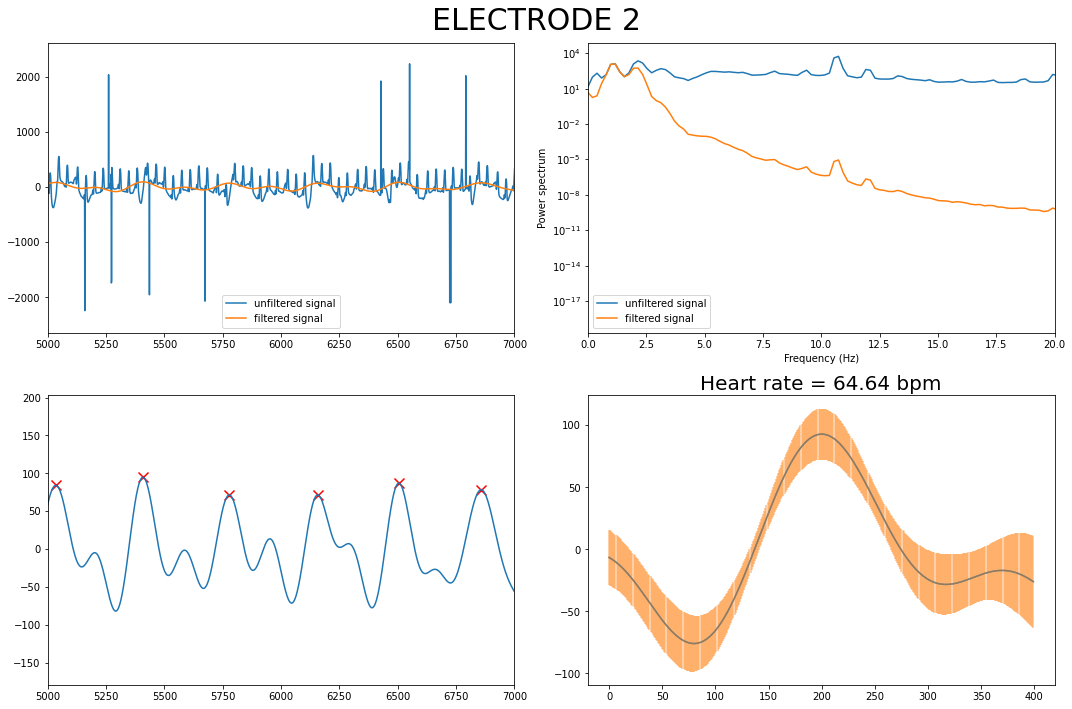

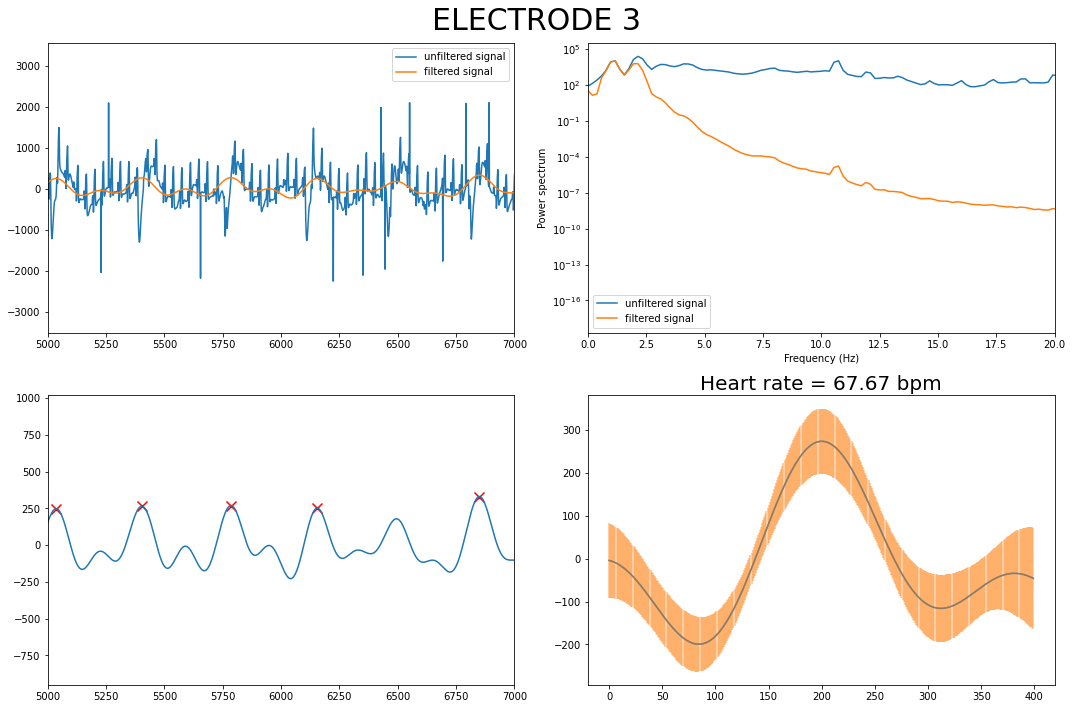

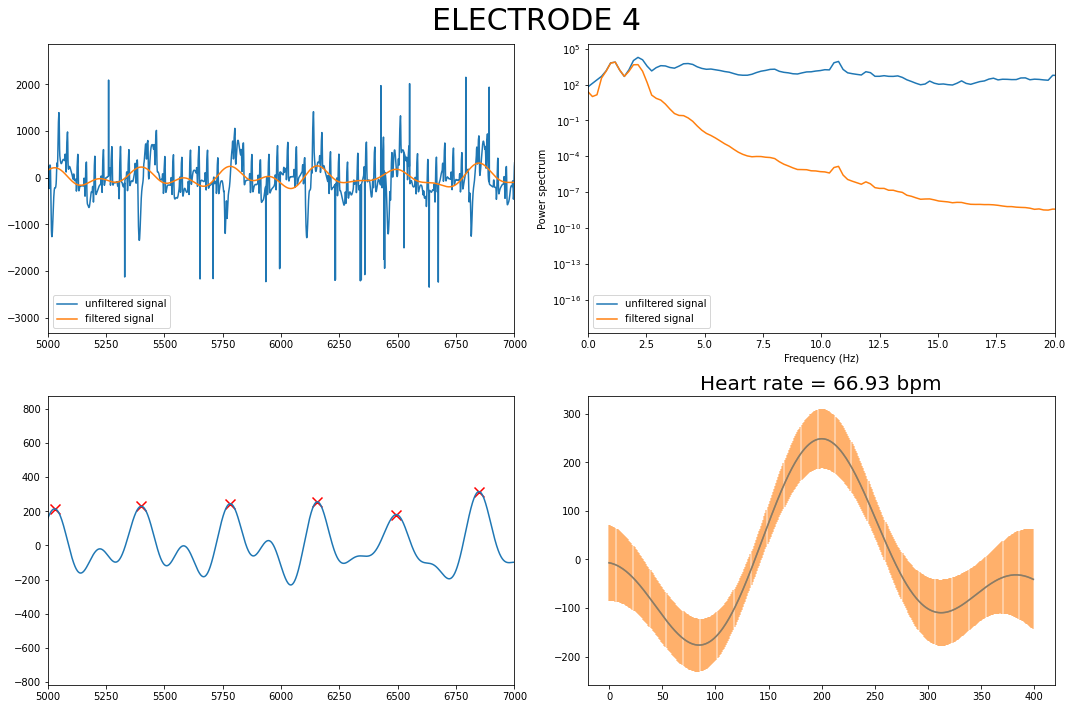

In [4]:
ground_ecg = ecg_signal[:,0]

for ii in range(1,4):
    signal = ecg_signal[:,ii] - ground_ecg
    generate_plots(signal, low_cut=low_cut, high_cut=high_cut, fs=fs, delta=delta, peak_rise=peak_rise)
    plt.suptitle("ELECTRODE %d" % (ii+1), size=30)
    plt.tight_layout()

# Electrode 4 as ground

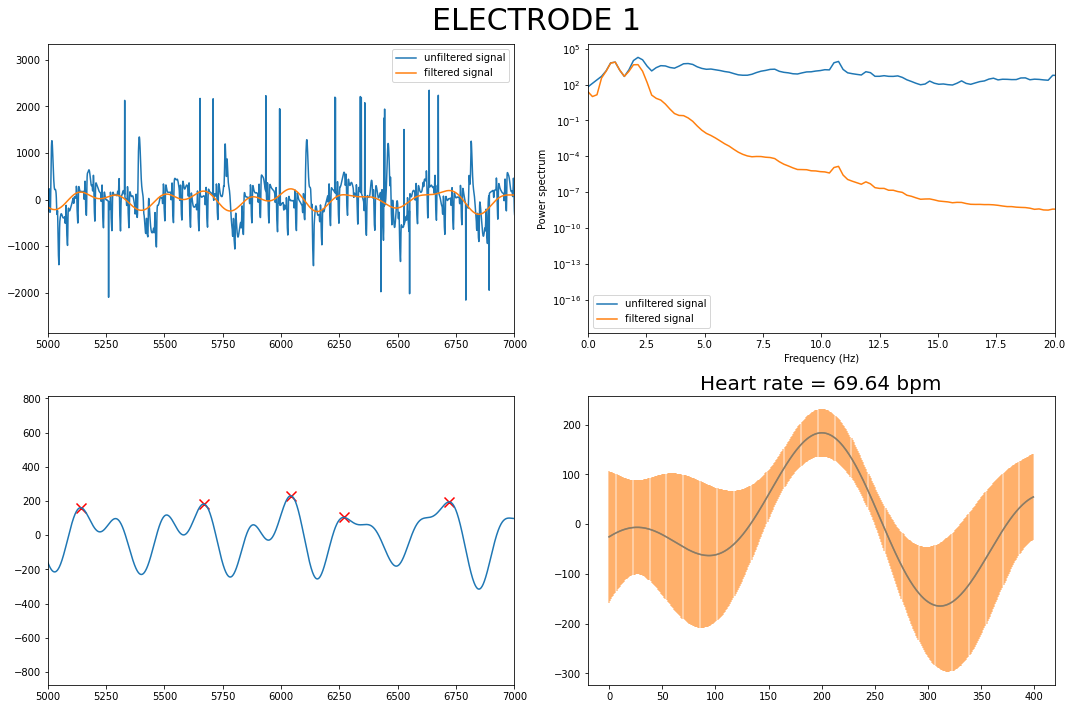

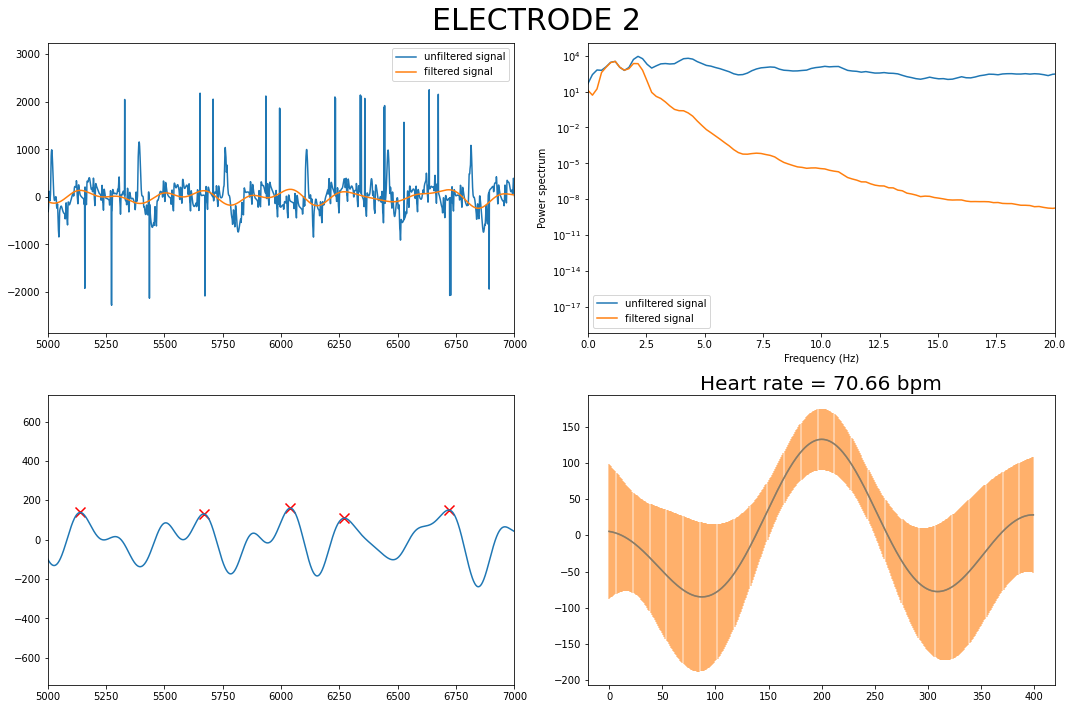

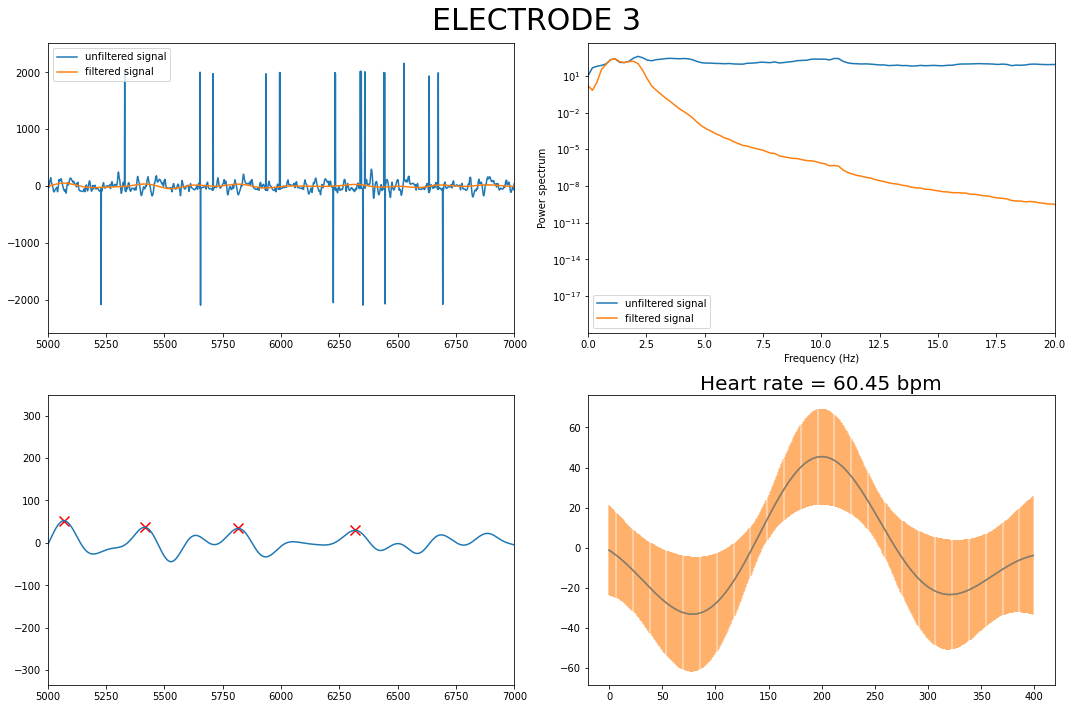

In [5]:
ground_ecg = ecg_signal[:,-1]

for ii in range(3):
    signal = ecg_signal[:,ii] - ground_ecg
    generate_plots(signal, low_cut=low_cut, high_cut=high_cut, fs=fs, delta=delta, peak_rise=peak_rise)
    plt.suptitle("ELECTRODE %d" % (ii+1), size=30)
    plt.tight_layout()

# Average

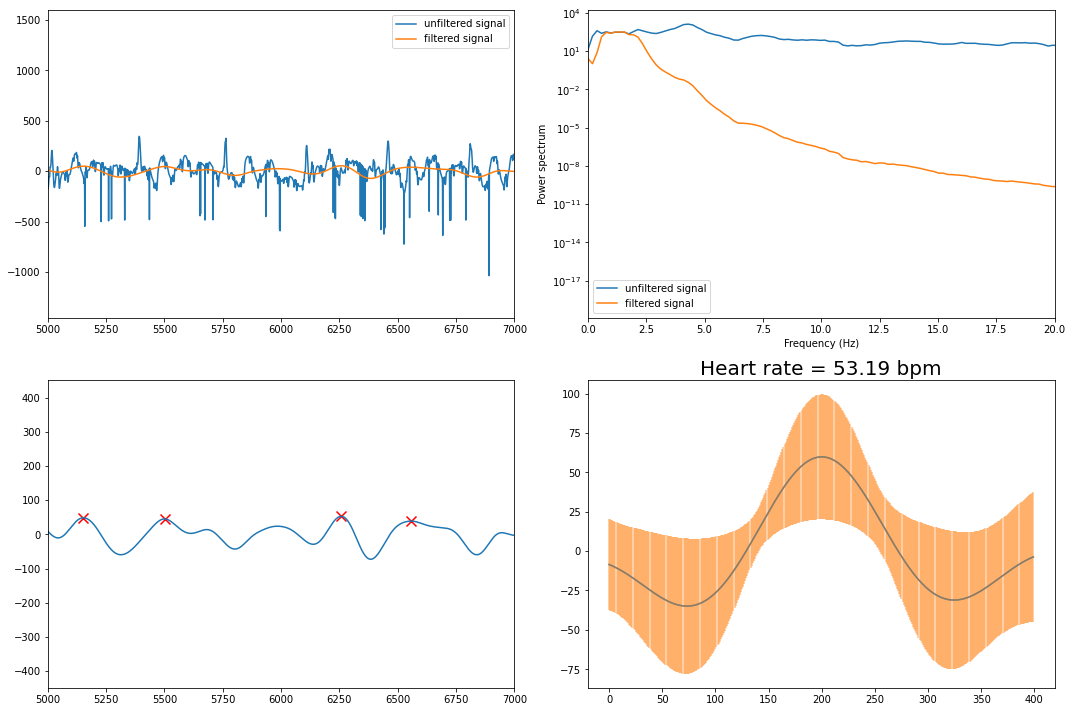

In [6]:
signal = np.mean(ecg_signal, axis=1)
generate_plots(signal, low_cut=low_cut, high_cut=high_cut, fs=fs, delta=delta, peak_rise=peak_rise)